<a href="https://colab.research.google.com/github/Chameee/cv_final_project/blob/master/cv_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Final Project

This notebook contains all codes for this project, which is divided into 3 parts:

- Data Preparation
- Model Construction ( include model A,B,C )
- Training and visualization

In [2]:
!pip install einops
import math

'''
author: Ruming Tang, 18307110152
date: 2021.06
'''

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import torchvision

## Data Preparation

Here we use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset as Training and testing data.


In [3]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Visualization of some traning examples.

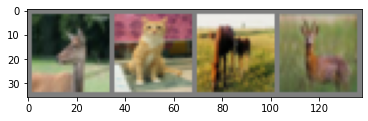

 deer   cat horse  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

For simplicity of debugging our designed model, we using a single 32 * 32 image.

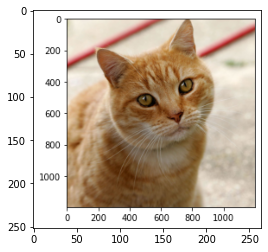

In [6]:
img = Image.open('./cat.png')

fig = plt.figure()
plt.imshow(img)


In [7]:
# resize to imagenet size
transform = Compose([Resize((32, 32)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dimensions
x.shape

torch.Size([1, 4, 32, 32])

In [8]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)


## Model Construction
### ViT model


In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 4, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

PatchEmbedding()(x).shape


torch.Size([1, 4, 768])

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 4, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

PatchEmbedding()(x).shape


torch.Size([1, 4, 768])

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 4, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x

PatchEmbedding()(x).shape



torch.Size([1, 5, 768])

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 4, patch_size: int = 16, emb_size: int = 768, img_size: int = 32):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

PatchEmbedding()(x).shape



torch.Size([1, 5, 768])

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out



In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 5, 768])

In [15]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x



In [16]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [17]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))



In [18]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape



torch.Size([1, 5, 768])

In [19]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])



In [20]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))



In [21]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 32,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )


In [22]:
summary(ViT(), (3, 32, 32), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 2, 2]         590,592
         Rearrange-2               [-1, 4, 768]               0
    PatchEmbedding-3               [-1, 5, 768]               0
         LayerNorm-4               [-1, 5, 768]           1,536
            Linear-5              [-1, 5, 2304]       1,771,776
           Dropout-6              [-1, 8, 5, 5]               0
            Linear-7               [-1, 5, 768]         590,592
MultiHeadAttention-8               [-1, 5, 768]               0
           Dropout-9               [-1, 5, 768]               0
      ResidualAdd-10               [-1, 5, 768]               0
        LayerNorm-11               [-1, 5, 768]           1,536
           Linear-12              [-1, 5, 3072]       2,362,368
             GELU-13              [-1, 5, 3072]               0
          Dropout-14              [-1, 

### Modified version of [VGG](https://arxiv.org/abs/1409.1556)

In [23]:
import torch.nn as nn

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 'M'],
}

def vgg_modified():
    return VGG(make_layers(cfg['A']))

In [24]:
summary(vgg_modified(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Modified version of [ResNet](https://arxiv.org/abs/1512.03385)

In [25]:
__all__ = ['resnet152']


model_urls = {
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        self.conv1_input = x.clone()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet_modified(**kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 10, 58, 3], **kwargs)
    return model

In [26]:
summary(resnet_modified(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,160
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,640
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,640
      BatchNorm2d-14            [-1, 25

Calculate total parameters and FLOPs of **Vit**, modified version of **vgg**, modified version of **ResNet**

In [28]:
!pip install ptflops
from ptflops import get_model_complexity_info

  Created wheel for ptflops: filename=ptflops-0.6.5-cp37-none-any.whl size=8870 sha256=706f0b78944ae3b07964cb44f47ffee976b78bf3046f2ef13199e7e14837cd96
  Stored in directory: /root/.cache/pip/wheels/ef/ad/e9/892acc135cbdac3ba50eeb2d5912eedcf208215da54bd69e16
Successfully built ptflops


**Vit**

In [29]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(ViT(), (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ViT(
  85.616 M, 99.950% Params, 0.427 GMac, 100.000% MACs, 
  (0): PatchEmbedding(
    0.591 M, 0.689% Params, 0.002 GMac, 0.553% MACs, 
    (projection): Sequential(
      0.591 M, 0.689% Params, 0.002 GMac, 0.553% MACs, 
      (0): Conv2d(0.591 M, 0.689% Params, 0.002 GMac, 0.553% MACs, 3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    85.018 M, 99.251% Params, 0.425 GMac, 99.445% MACs, 
    (0): TransformerEncoderBlock(
      7.085 M, 8.271% Params, 0.035 GMac, 8.287% MACs, 
      (0): ResidualAdd(
        2.362 M, 2.758% Params, 0.012 GMac, 2.763% MACs, 
        (fn): Sequential(
          2.362 M, 2.758% Params, 0.012 GMac, 2.763% MACs, 
          (0): LayerNorm(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            2.362 M, 2.758% Params, 0.012 GMac, 2.763% MACs, 
            (qkv): Linear(1.772 M, 2.068% Params, 

Modified version of **vgg** (The same FLOPs as **Vit**)

In [30]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(vgg_modified(), (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

VGG(
  18.785 M, 100.000% Params, 0.428 GMac, 100.000% MACs, 
  (features): Sequential(
    18.255 M, 97.176% Params, 0.427 GMac, 99.876% MACs, 
    (0): Conv2d(0.002 M, 0.010% Params, 0.002 GMac, 0.429% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.015% MACs, inplace=True)
    (2): Conv2d(0.037 M, 0.197% Params, 0.038 GMac, 8.841% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.015% MACs, inplace=True)
    (4): MaxPool2d(0.0 M, 0.000% Params, 0.0 GMac, 0.015% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(0.074 M, 0.393% Params, 0.019 GMac, 4.420% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.008% MACs, inplace=True)
    (7): Conv2d(0.148 M, 0.786% Params, 0.038 GMac, 8.833% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): 

Modified version of **ResNet** (The same parameters as **Vit**)

In [31]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(resnet_modified(), (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  85.442 M, 100.000% Params, 0.346 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.011% Params, 0.002 GMac, 0.700% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.009% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.005% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.0 GMac, 0.005% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.217 M, 0.254% Params, 0.014 GMac, 4.035% MACs, 
    (0): Bottleneck(
      0.076 M, 0.089% Params, 0.005 GMac, 1.405% MACs, 
      (conv1): Conv2d(0.004 M, 0.005% Params, 0.0 GMac, 0.077% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.002% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M, 0.043% Params, 0.002 GMac, 0.682%

### Training and visualization
In this section, we will train these 3 models in training set and get performance in testing set.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
import torch.optim as optim

Training **ViT** model.

In [34]:
vit_model = ViT().to(device)
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)



In [35]:
loss_list_vit, step_list_vit = [], []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer_vit.zero_grad()

        # forward + backward + optimize
        outputs = vit_model(inputs)
        loss = criterion_vit(outputs, labels)
        loss.backward()
        optimizer_vit.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list_vit.append(running_loss)
            step_list_vit.append(i * epoch)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.409
[1,  4000] loss: 1.873
[1,  6000] loss: 1.808
[1,  8000] loss: 1.740
[1, 10000] loss: 1.690
[1, 12000] loss: 1.651
[2,  2000] loss: 1.603
[2,  4000] loss: 1.558
[2,  6000] loss: 1.556
[2,  8000] loss: 1.538
[2, 10000] loss: 1.526
[2, 12000] loss: 1.497
[3,  2000] loss: 1.451
[3,  4000] loss: 1.436
[3,  6000] loss: 1.436
[3,  8000] loss: 1.436
[3, 10000] loss: 1.412
[3, 12000] loss: 1.402
[4,  2000] loss: 1.356
[4,  4000] loss: 1.357
[4,  6000] loss: 1.352
[4,  8000] loss: 1.351
[4, 10000] loss: 1.324
[4, 12000] loss: 1.335
[5,  2000] loss: 1.283
[5,  4000] loss: 1.294
[5,  6000] loss: 1.257
[5,  8000] loss: 1.269
[5, 10000] loss: 1.263
[5, 12000] loss: 1.272
Finished Training


Testing **ViT** model.

In [37]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = vit_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 52 %


In [38]:
torch.save(vit_model, './vit_model_epo5.pth')

Training **vgg_modified** model.

In [39]:
torch.cuda.empty_cache()

In [40]:
vgg_model = vgg_modified().to(device)
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

In [41]:
loss_list_vgg, step_list_vgg = [], []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer_vgg.zero_grad()

        # forward + backward + optimize
        outputs = vgg_model(inputs)
        loss = criterion_vgg(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list_vgg.append(running_loss)
            step_list_vgg.append(i * epoch)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.301
[1,  4000] loss: 2.240
[1,  6000] loss: 2.075
[1,  8000] loss: 1.969
[1, 10000] loss: 1.898
[1, 12000] loss: 1.838
[2,  2000] loss: 1.729
[2,  4000] loss: 1.690
[2,  6000] loss: 1.637
[2,  8000] loss: 1.578
[2, 10000] loss: 1.511
[2, 12000] loss: 1.465
[3,  2000] loss: 1.371
[3,  4000] loss: 1.342
[3,  6000] loss: 1.304
[3,  8000] loss: 1.256
[3, 10000] loss: 1.199
[3, 12000] loss: 1.159
[4,  2000] loss: 1.082
[4,  4000] loss: 1.045
[4,  6000] loss: 1.021
[4,  8000] loss: 0.995
[4, 10000] loss: 0.960
[4, 12000] loss: 0.971
[5,  2000] loss: 0.867
[5,  4000] loss: 0.867
[5,  6000] loss: 0.876
[5,  8000] loss: 0.855
[5, 10000] loss: 0.809
[5, 12000] loss: 0.777
Finished Training


Testing **vgg_modified** model.

In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = vgg_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


In [43]:
torch.save(vgg_model, './vgg_model_epo5.pth')

Training **resnet_modified** model.

In [44]:
torch.cuda.empty_cache()

In [45]:
resnet_model = resnet_modified().to(device)
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [46]:
loss_list_resnet, step_list_resnet = [], []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize
        outputs = resnet_model(inputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list_resnet.append(running_loss)
            step_list_resnet.append(i * epoch)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 5.953
[1,  4000] loss: 5.235
[1,  6000] loss: 4.641
[1,  8000] loss: 4.135
[1, 10000] loss: 3.843
[1, 12000] loss: 3.660
[2,  2000] loss: 3.490
[2,  4000] loss: 3.282
[2,  6000] loss: 3.174
[2,  8000] loss: 3.089
[2, 10000] loss: 3.027
[2, 12000] loss: 2.966
[3,  2000] loss: 2.849
[3,  4000] loss: 2.813
[3,  6000] loss: 2.769
[3,  8000] loss: 2.707
[3, 10000] loss: 2.693
[3, 12000] loss: 2.639
[4,  2000] loss: 2.637
[4,  4000] loss: 2.603
[4,  6000] loss: 2.606
[4,  8000] loss: 2.592
[4, 10000] loss: 2.574
[4, 12000] loss: 2.536
[5,  2000] loss: 2.514
[5,  4000] loss: 2.516
[5,  6000] loss: 2.507
[5,  8000] loss: 2.494
[5, 10000] loss: 2.491
[5, 12000] loss: 2.502
Finished Training


Testing **resnet_modified** model.

In [47]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = resnet_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 11 %


In [48]:
torch.save(resnet_model, './resnet_model_epo5.pth')

### Visualization of Training Loss of 3 models

In [49]:
len(loss_list_vgg)

30

In [51]:
step_list = [2000 * i for i in range(30)]
step_list

[0,
 2000,
 4000,
 6000,
 8000,
 10000,
 12000,
 14000,
 16000,
 18000,
 20000,
 22000,
 24000,
 26000,
 28000,
 30000,
 32000,
 34000,
 36000,
 38000,
 40000,
 42000,
 44000,
 46000,
 48000,
 50000,
 52000,
 54000,
 56000,
 58000]

In [52]:
from matplotlib import pyplot as plt


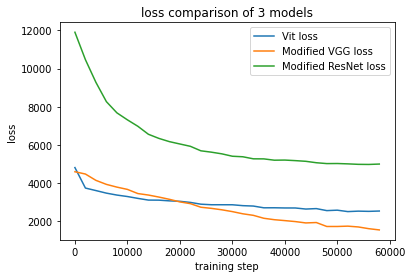

In [53]:

plt.plot(step_list, loss_list_vit, label = "Vit loss")
plt.plot(step_list, loss_list_vgg, label = "Modified VGG loss")
plt.plot(step_list, loss_list_resnet, label = "Modified ResNet loss")
plt.xlabel('training step')
plt.ylabel('loss')
plt.title('loss comparison of 3 models')
plt.legend()
plt.show()